# Livrable 1 correction - Groupe 2

#### Dans ce livrable, nous allons fournir un modèle de classification binaire. Ce modèle, qui prend un dataset en entrée, détermine pour chaque image si c'est une photo ou non. 

## 1.   Importation des données et prétraitement

Dans cette partie, nous allons détailler la méthode d'importation des données, et toutes les étapes de prétraitement requises pour s'assurer que notre modèle produise des résultats satisfaisants.

### a. spécification des chemins

Avant de commencer toutes exécutions du code, nous devons nous assurer que le format de notre dataset est adéquat. Il faut que le dataset suit l'architecture suivante :

![Screenshot%202022-10-06%20at%2015.53.34.png](https://cdn.discordapp.com/attachments/1022809324805947393/1027963973267632208/data_architecture.png)

Soit, un dossier avec un sous dossier pour chaque classe présente dans le dataset.

Il est donc demandé dans le code suivant de fournir la classe qu'on veut prédire ("Photo" dans notre cas), le nombre de classes au total (ici 5). Ensuite, il faut spécifier le chemin du dossier contenant notre dataset, un chemin pour obtenir les logs (relatifs aux exécutions du modèle) et enfin un nom à ce projet.

In [15]:
import os
import pathlib
import warnings
warnings.filterwarnings('ignore')

### data information - class to predict
TRUE_CLASS = "Photo"
N_CLASSES = 5

### data information - paths and names
data_dir = pathlib.Path('/Users/soja/Downloads/DATASCIENCEG2') 
log_dir = "/Users/soja/Downloads/LIVRABLE1G2"
project_name = "L1G2"

### b. suppression des dossiers cachés et calcul du nombre de fichiers dans chaque dossier

Pour le bon fonctionnement de l'importation des données, il est impératif de supprimer les éventuels dossiers cachés présents dans notre dossier dataset. 

Nous calculons également le nombre de fichiers présents dans chaque dossier, puis retenons le dossier avec le moins de fichiers. Cette information nous sera utile afin de s'assurer de l'équilibre des données, expliqué plus bas.

In [16]:
data=[]

# calcul du dossier le plus petit : n_files
folder_length = []
for folder in os.listdir(data_dir):
    if folder.startswith('.'):
        os.remove(os.path.join(data_dir, folder))
    else:
        folder_length.append(len(os.listdir(str(data_dir)+'/'+folder)))
        n_files = min(folder_length)

print("Le dossier avec le moins de fichiers en a", n_files, '.')

Le dossier avec le moins de fichiers en a 606 .


### c. suppression des images mal encodées et importation équilibrée des données

- ###### images mal encodées

Dans notre carde, nous définissons les images corrompues comme tout fichier non conformément encodé. [Selon Keras](https://keras.io/examples/vision/image_classification_from_scratch/#filter-out-corrupted-images), il est possible d'identifier une image corrompue si la chaine de caratcères "JFIF" n'est pas présente dans son header. Après avoir executé notre code, il y a environ 1000 images supprimées au total. 

- ###### importation équilibrée

Ensuite, les données sont importés de manière équilibrée grâce à un calcul mathématique dans un Dataframe. Le but de ce traitement est de s'assurer que nous ayons autant de Photos que d'images qui ne sont pas des photos dans notre dataset, soit un ratio de 50:50.

In [17]:
import pandas as pd 
import tensorflow as tf

# importation equilibree des données
# supprimer les fichiers corrompus

n_corrupted_files = 0
for folder in os.listdir(data_dir):
        index = 0
        for f in os.listdir(os.path.join(data_dir,folder)):
            path = os.path.join(data_dir, folder, f)
            try:
                fobj = open(path, "rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            finally:
                fobj.close()
                if folder != TRUE_CLASS:
                    label="other"
                    if index == int((4+(4/(N_CLASSES-1)))*n_files):
                        break
                elif folder == TRUE_CLASS:
                    label="photo"
                    if index == n_files*4*(N_CLASSES-1):
                        break
                index+=1
                data.append([path, label])
            if not is_jfif:
                n_corrupted_files += 1
                os.remove(path)

print("%d images supprimées" % n_corrupted_files)

dataset = pd.DataFrame(data, columns=['image', 'label'])

photo = dataset[dataset['label']=="photo"]
other = dataset[dataset['label']=="other"]
print("Dans ce dataset de", len(dataset), "images, il y a",
      len(photo), "photos et", len(other), "autres images.")

208 images supprimées
Dans ce dataset de 19392 images, il y a 9696 photos et 9696 autres images.


Nous faisons le choix de n'utiliser qu'une partie des données pour entrainer notre modèle. En effet, l'utilisation de l'ensemble du jeu données, coposé d'environ 50 000 images, pourrais significativement alourdir l'exécution de l'apprentissage sans but réel. En effet, nous avons 10 000 photos uniquement. Si nous appliquons le ratio de 50:50, nous devons utiliser 10 000 images maximum des autres dossiers, soit 20 000 au total. Utiliser plus que 20 000 images désiquilibrerait donc le dataset.

Nous jugeons donc qu'utiliser uniquement 20000 images de ces données est une décision qui nous permet de lancer l'entrainement du modèle plusieurs fois (donc d'améliorer ses performances) sans pour autant pénaliser l'apprentissage.

### d. séparation du dataset en train, test et validation

Il faut à présent séparer le dataset. Il nous faut une partie pour entrainer le modèle (train), et une partie pour vérifier la performance de notre modèle (validation). Dans notre cas, nous isolons également une partie du dataset appelée test pour tester notre modèle après l'avoir enregistré.

Il est très important de garder le ratio de 50:50 Photos et autres images. Nous utilisions pour cela le mot clé "stratify". 

In [18]:
from sklearn.model_selection import train_test_split

# split train and test
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42,
                                       shuffle=True, stratify=dataset['label'])

Nous avons maintenant le dataset que nous allons utiliser pour la entrainer notre moder : train_set. Ce set est sous forme de Dataframe, nous allons donc le transformer en Generator pour pouvoir lire les images.

Dans le code suivant, la classe ImageDataGenerator est instanciée. Ici, nous effectuons une remise à l'échelle, ou Rescaling. 

La mise à l'échelle consiste à changer l'intervalle des données (pixels) que nous avons. Nos images d'origine consistent en des coefficients RGB dans l'intervalle 0-255, mais de telles valeurs seraient trop élevées pour que notre modèle puisse les traiter, nous ciblons donc des valeurs entre 0 et 1 en remettant à l'échelle les valeurs avec une multiplication par 1./255.

In [23]:
import keras
from keras.preprocessing.image import ImageDataGenerator

# init the generator class
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        validation_split=0.20,
)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)


# init train, validation and test generators from dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_set,
    x_col="image",
    y_col="label",
    classes=["other", "photo"],
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42,
    stratify=train_set['label'],
)
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=train_set,
    x_col="image",
    y_col="label",
    classes=["other", "photo"],
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed=42,
    stratify=train_set['label'],
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_set,
    x_col="image",
    y_col="label",
    batch_size=200,
    classes=["other", "photo"],
    class_mode='binary',
    shuffle=False,
)

Found 12284 validated image filenames belonging to 2 classes.
Found 3071 validated image filenames belonging to 2 classes.
Found 3829 validated image filenames belonging to 2 classes.


## 2. Visualisation des données

Nous avons maintenant 3 generator, train_generator, valid_generator et test_generator. Visualisons les images ayant subi la data augmentation du train_generator.

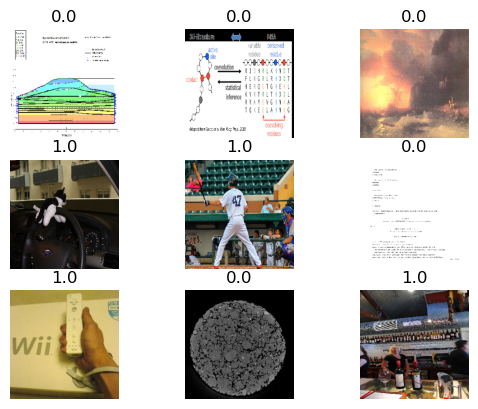

In [20]:
import matplotlib.pyplot as plt
import numpy as np

### image visualisation
for i in range(9):
    plt.subplot(330 + 1 + i)
    images, labels = train_generator.next()
    image = (images[0]*255).astype('uint8')
    plt.imshow(image)
    plt.title(labels[0])
    plt.axis('off')
plt.show()

## 3. Première architecture du modèle

Pour la classification binaire d'images, nous avons choisi une architecture CNN (Convolutional Neural Network). Dans notre cas, nous avons choisi d'avoir deux couches convolutives (Convolution Layers). Ces couches convolutives servent à réduire la dimension des images tout en prenant en compte le voisinage de chaque partie analysée. En effet, l'image se présente sous la forme d'une matrice, la convolution est le processus d'ajout de chaque élément de l'image à ses voisins locaux, pondérés par le noyau. Après chaque couche convolutive, nous avons une couche de regroupement (Pooling Layer). La couche de regroupement effectue une opération de sous-échantillonnage le long des dimensions spatiales et réduit la dimensionnalité de chaque carte d'entités mais conserve les informations les plus importantes. Le regroupement maximal est un type de regroupement qui extrait uniquement les fonctionnalités qui ont la valeur la plus élevée. 

A la suite des couches de convolution et de regroupement, il y a une couche Fully Connected. Chaque neurone de cette couche est connecté à tous les autres neurones de la couche adjacente. La couche entièrement connectée utilise la fonction sigmoid pour la classe de commutation de l'image d'entrée.

In [90]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

#CONFIG
AUTOTUNE = tf.data.experimental.AUTOTUNE

def create_model():
      model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(256,256, 3)),
            tf.keras.layers.MaxPooling2D((2,2)),

            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2,2)),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128,
                                  activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')

      ])
      model.compile(optimizer=Adam(1e-4),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5)])
      return model

### a. pourquoi deux couches convolutives?

Dans le modèle ci dessus, il y a donc deux couche convolutives. 

La première couche convolutive a 32 filtres, avec un stride par defaut de 1 et un kernel size de 3,3. Elle est suivie de la première couche de regroupement, qui a un pool size de 2,2 et un stride par défaut de 1.

La deuxième couche a 64 filtres, un stride par défaut de 1 et un kernel size de 3,3. Elle est suivie de la première couche de regroupement, qui a un pool size de 2,2 et un stride par défaut de 1.

Après plusieurs recherches, le choix de ces paramètres pour ces couches ont été faits car il semble qu'il n'y ait pas de calcul absolu permettant de trouver les paramètre les plus optimaux. Nous avons donc testé quelques fois ce modèle avec deux couches covolutives (et deux couche de regroupement) ou avec trois couches convolutives (et trois couches de regroupement) sans différence significative quand à la loss value et à l'accuracy. [(source)](https://stackoverflow.com/questions/24509921/how-do-you-decide-the-parameters-of-a-convolutional-neural-network-for-image-cla)

### b. pourquoi la fonction d'activation ReLU?

Les deux couches de convolution utilisent ReLU (Rectified Linear Units) comme fonction d'activation. ReLU est une fonction à moitié rectifiée, c'est-à-dire que pour toutes les entrées inférieures à 0, la valeur est 0 tandis que pour tout ce qui est positif (par exemple 10, 15, 34) la valeur est retenue. Le principal avantage de l'utilisation de la fonction ReLU par rapport aux autres fonctions d'activation est qu'elle n'active pas tous les neurones en même temps. Cela signifie que les neurones ne seront désactivés que si la sortie de la transformation linéaire est inférieure à 0.

### c. combien de neurones de la couche Fully Connected?

Nous commencons notre modèle avec 128 neurones. Ce choix a été fait après plusieurs recherches ciblant le nombre optimal de neurones pour une couche Fully Connected. Comme écrit [ici](https://ai.stackexchange.com/questions/11835/how-do-i-choose-the-number-of-neurons-in-the-fully-connected-layer-before-the-so), il n'y a pas de théorie nous permettant de directement obtenir un nombre de neurones le plus optimisé possible. Le nombre de neurones sur la couche Fully Connected sera donc un hyperparamètre à optimiser plus tard.

### d. pourquoi la fcontion d'activation sigmoid pour la couche de sortie?

A la suite de notre dernière couche cachée, il y a la couche de sortie. Cette couche possède un seul neurone, qui utilise la fonction d'activation 'sigmoid'. Elle transforme toute valeur du domaine( -∞,+ ∞) en un nombre compris entre 0 et 1. La fonction sigmoïde est utilisée pour prédire la probabilité d'une variable binaire.

### e. optimisation algorithm et learning rate, comment choisir?

Les algorithmes d'optimisation sont les outils qui permettent de mettre à jour en continu les paramètres du modèle et de minimiser la valeur de la fonction de perte, telle qu'évaluée sur les données d'apprentissage. Choisir le bon algorithme d'optimisation est une partie très importante de l'architecture du modèle. 

Selon un article de [analyticsvidhya](https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/), on peut voir les différents avantages et défauts des algorithmes d'optimisation les plus connus, tels que AdaDelta, SGD, AdaGrad ou encore Adam. Après plusieurs lectures et recherche, on voit que l'algorithme d'optimisation Adam est le plus adapté à notre situation : en effet, Adam combine les fonctionnalités de nombreux algorithmes d'optimisation dans une règle de mise à jour assez robuste, et tout cela en ayant un temps d'exécution rapide, en nécésstant peu de mémoire et moins de réglages que tout autre algorithme d'optimisation.

Maintenant que nous avons choisi l'algorithme d'optimisation Adam, nous devons définir son learning rate. Adam est un algorithme adaptatif, il s'auto-ajuste pendant l'entrainement du modèle. Dans de nombreux cas, les hyperparamètres par défaut fournissent déja les résulats les plus optimaux. [Comme démontré ici](https://stackoverflow.com/questions/42966393/is-it-good-learning-rate-for-adam-method), le réglage du taux d'apprentissage peut parfois conduire à des améliorations, mais la plage des meilleures valeurs connues est également plus petite par rapport à d'autres algorithmes. 

Nous avons donc fait un test avec un learning rate de 0.1, mais cela nous a donné une précision coincée à 0.5. Nous avons donc cherché des cas d'études, et comme on peut (voir sur ce forum)[https://stackoverflow.com/questions/60261103/keras-model-not-training-layers-validation-accuracy-always-0-5], un utilisateur démontre comment le learning rate peut affecter la précision de prédictions binaires. 

<img src=https://i.stack.imgur.com/oR3SI.png width="600">

Nous avons donc décidé de commencer nos tests avec un learning rate de 1e-4, puis d'effectuer plusieurs tests par la suite avec d'autres valeurs lors de l'optimisation des hyperparamètres.

## 4. Premiers tests

### a. choix du nombre d'epoch

Le choix du nombre d'epoch est également un paramètre à chercher par essai. Selon ce qu'on a pu lire sur différentes plateformes, on constate que le meilleur moyen de savoir le nombre d'epoch optimal est en effectuant des tests [(source)](https://gretel.ai/gretel-synthetics-faqs/how-many-epochs-should-i-train-my-model-with). Nous avons donc choisi dans un premier temps d'effectuer un entrainement avec 25 epochs.

### b. Early Stopping

Viens s'ajouter au nombre d'Epochs le Early Stopping. La fonction tf.keras.callbacks.EarlyStopping permet d'eviter d'entrainer un modèle trop longtemps si les métriques surveillées n'évoluent pas. Dans notre cas, la métrique que nous choisissons de surveiller est 'val_loss' soit la fonction de perte sur le dataset de validation.

In [43]:
model = create_model()

history = model.fit(train_generator, epochs=25, validation_data=valid_generator, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/25


2022-10-15 19:04:10.126664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


384/384 [==============================] - ETA: 0s - loss: 0.4305 - binary_accuracy: 0.7458

2022-10-15 19:05:59.443748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


384/384 [==============================] - 126s 327ms/step - loss: 0.4305 - binary_accuracy: 0.7458 - val_loss: 0.3408 - val_binary_accuracy: 0.8007
Epoch 2/25
384/384 [==============================] - 125s 326ms/step - loss: 0.3037 - binary_accuracy: 0.8474 - val_loss: 0.3058 - val_binary_accuracy: 0.8411
Epoch 3/25
384/384 [==============================] - 125s 326ms/step - loss: 0.2518 - binary_accuracy: 0.8759 - val_loss: 0.2859 - val_binary_accuracy: 0.8678
Epoch 4/25
384/384 [==============================] - 126s 326ms/step - loss: 0.1942 - binary_accuracy: 0.9117 - val_loss: 0.2929 - val_binary_accuracy: 0.8805
Epoch 5/25
384/384 [==============================] - 127s 329ms/step - loss: 0.1520 - binary_accuracy: 0.9310 - val_loss: 0.2758 - val_binary_accuracy: 0.8724
Epoch 6/25
384/384 [==============================] - 125s 325ms/step - loss: 0.1121 - binary_accuracy: 0.9554 - val_loss: 0.2690 - val_binary_accuracy: 0.8645
Epoch 7/25
384/384 [==============================]

Nous pouvons constater que notre modèle s'est entrainé pour seulement 9 epochs grâce au Early Stopping car la valeur de la fonction de perte ne s'améliorait plus. Passons maintenant à l'évaluation de notre modèle afin de comprendre comment l'améliorer.

## 5. Evaluations et premières prédictions 

### a. précision et fonction de perte

Voyons maintenant la précision et la fonction de perte de notre modèle sur les données train et validation.

- ###### Fonction de perte train et validation

On peut voir sur le tracé ci dessous que la fonction de perte du modèle sur le dataset train part de 0.43 et augmente au fil des epoch et atteint une valeur finale de 0.03, ce qui est une valeur minime. On peut donc imaginer que notre modèle est très performant. Cependant, la fonction de perte sur le dataset validation part de 0.35 et diminue un peu au fil des epochs, pour revenir à une valeur proche de 0.35, Ceci est donc un très mauvais score. la disparité de ces résultats entre les données train et validation laissent penser que le modèle n'est pas du tout performant.

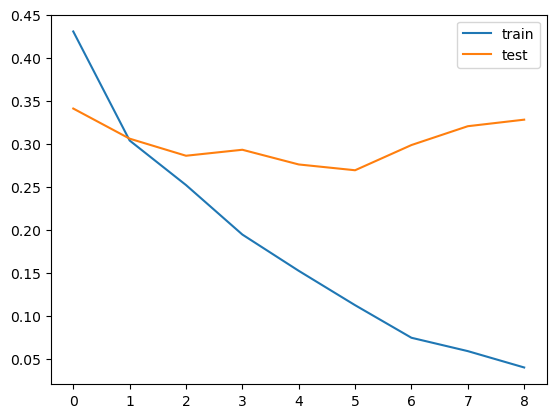

In [44]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

- ###### Précision train et validation

On peut voir sur le tracé ci dessous que la précision du modèle sur le dataset train part de 0.70 et augmente au fil des epoch et atteint une valeur de 0.98. On peut donc dire qu'elle progresse significativement. En revanche, la précision sur le dataset validation part de 0.80 environ et stagne le long des epochs, atteignant un maximum de 0.89. Ceci est un score très bas par rapport à la précision train.

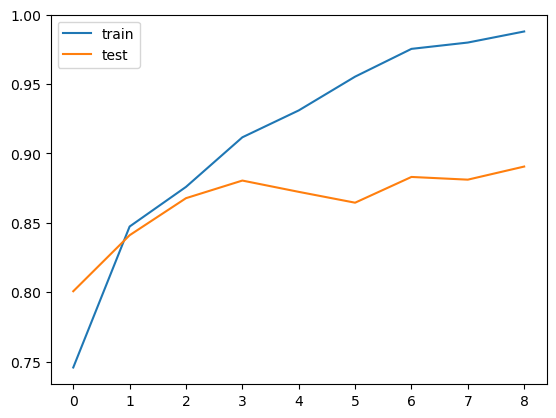

In [46]:
plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='test')
plt.legend()

### b. évaluation et prédictions

Afin de mieux comprendre le comportement du modèle, nous pouvons maintenant évaluer celui ci et faire des prédictions.

- ###### évaluation

In [56]:
evaluation = model.evaluate(test_generator, verbose=0)
print("Test loss:\t", evaluation[0])
print("Test accuracy:\t", evaluation[1])

Test loss:	 0.3397744596004486
Test accuracy:	 0.8835204839706421


Suite à l'évaluation du modèle sur les données test, on voit qu'on a une précision de l'ordre de 0.88 et une fonction de perte de l'ordre de 0.33. Ces résultats ne sont sont pas satisfaisant, étant donné la simplicité de la tâche. Voyons maintenant quelques résultats de prédiction de notre modèle sur ces mêmes données test.

- ###### prédictions

1/1 [==============================] - 0s 11ms/step


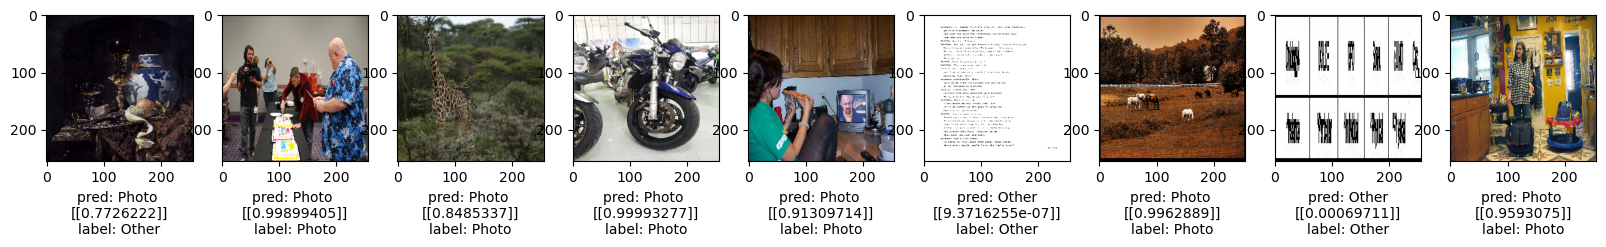

In [76]:
plt.figure(figsize=(20,20 ))

for image, label in test_generator:
    for i in range(9):
        ax =  plt.subplot(1, 9, i + 1)
        plt.imshow(image[i])
        X = np.expand_dims(image[i],axis=0)
        val = model.predict(X)
        l = "Other"
        if label[i] == 1:
            l = "Photo"
        if val > 0.5:
            plt.xlabel("pred: Photo " + "\n" + str(val)+ "\n" + "label: " + l,fontsize=10)
        else:
            plt.xlabel("pred: Other" + "\n" + str(val)+ "\n"+ "label: " + l,fontsize=10)
    break

La couche de sortie de notre modèle nous forunit une probabilité que l'image d'entrée soit une Photo ou non. Ici, on choisi donc d'afficher "Photo" si la probabilité de sortie que nous fournit notre modèle est supérieure à 0.5. 

On voit donc que pour un échantillon de 9 images, le modèle se trompe sur une seule image, la 1ere. En effet, cette image est en réalité une peinture, mais elle a été prédite en tant que photo. On peut imaginer que les couleures similaires aux couleurs naturelles sur l'image laissent le modèle penser que c'est une photo.

On a donc sur cet échantillon de 9 images une précision de 0.88, ce qui représente bien la précision de notre modèle sur nos données validation, mais pas sur nos données d'entrainement.

### c. observations

Lorsque le modèle montre de bon résultats sur les données train et des résultats pas très satisfaisants sur les données validation et test, on dit que le modèle fait du sur-apprentissage car il mémorise les données d'entrainement et est incapable de généraliser les aquis sur des exemples nouveaux [(source)](https://docs.aws.amazon.com/machine-learning/latest/dg/model-fit-underfitting-vs-overfitting.html).

C'est ce que l'on voit sur les deux précédents graphiques et les évaluations, on peut donc en déduire que le modèle fait du sur-apprentissage, nous allons donc devoir trouver des solutions pour le faire évoluer.

## 6. Solutions au sur-apprentissage

Comme énoncé plus haut, notre modèle fait du sur-apprentissage. Il y a donc deux solutions que nous pouvons implémenter afin d'aider le modèle à généraliser les informations et les patterns qu'il trouve dans les données train aux données de test.

### a. data augmentation

La Data Augmentation est un principe réccurent lorsque nous avons du sur-apprentissage. Par exemple, un modèle de classification formé sur trois images sera limité à la reconnaissance et à la classification de ces images exactes. Même l'ajout de légères variations aux données améliorera la généralisiation de notre modèle.

Le principe de Data augmentation consiste à modifier les images d'un dataset, en y faisant des changements géométriques telles que retourner une image, la translater, lui faire une rotation ou lui ajouter du bruit. Toutes ces modifications font que le dataset devient diversifié, ce qui va améliorer la précision de notre modèle, puisque l'apprentissage se fera sur des images diverses et variées.

Dans notre cas, nous avons assez de données, nous n'avons donc pas besoin d'ajouter des données supplémentaires. Nous allons simplement appliquer des modifications sur les données déja existantes.

Dans le code suivant, la classe ImageDataGenerator est ré-instanciée. Pour le train_set, nous lui appliquons des paramètres de data augmentation. Pour le test_set, il n'y a pas besoin de faire ceci car ce set ne sera pas utilisé lors de l'entrainement de notre modèle.

In [78]:
# init the generator class
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20,
)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)


# init train, validation and test generators from dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_set,
    x_col="image",
    y_col="label",
    classes=["other", "photo"],
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42,
    stratify=train_set['label'],
)
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=train_set,
    x_col="image",
    y_col="label",
    classes=["other", "photo"],
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed=42,
    stratify=train_set['label'],
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_set,
    x_col="image",
    y_col="label",
    classes=["other", "photo"],
    class_mode='binary',
    shuffle=False,
)

Found 12284 validated image filenames belonging to 2 classes.
Found 3071 validated image filenames belonging to 2 classes.
Found 3829 validated image filenames belonging to 2 classes.


Visualisons maintenant les images modifiées ci dessous.

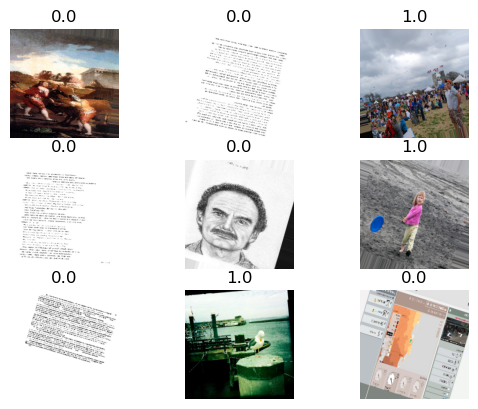

In [80]:
### image visualisation
for i in range(9):
    plt.subplot(330 + 1 + i)
    images, labels = train_generator.next()
    image = (images[0]*255).astype('uint8')
    plt.imshow(image)
    plt.title(labels[0])
    plt.axis('off')
plt.show()

### b. dropout

Une deuxième soluations pour éviter d'avoir du sur-apprentissage est l'ajout de couches Dropout.

En effet, une couche de Droput "enlève" les connections d'un neurone. Si le neurone "enlevé" est un neurone qui ne fournit aucune information, les neurones du réseau reçoivent un signal positif par rétropropagation et sont capables de mieux apprendre en l'absence d'un nœud négatif. En revanche, si le neurone "enlevé" est un neurone qui fournit des informations importantes pour la prédiction, le réseau doit apprendre une représentation séparée des données dans d'autres neurones. Pour ces raisons, la couche de Dropout permet donc d'éviter d'avoir un surapprentissage sur le dataset d'entrainement.

Selon [ce poste](https://stackoverflow.com/questions/47892505/dropout-rate-guidance-for-hidden-layers-in-a-convolution-neural-network), un taux de dropout trop elevé peut entrainter du sous apprentissage, et pour les réseaux de neurones convolutifs, il vaudrait mieux utiliser un taux de drpout entre 0.1 et 0.2. Nous allons commencer d'abord par 0.2 puis essayer d'optimiser ce taux plus tard. 

In [91]:
#CONFIG
AUTOTUNE = tf.data.experimental.AUTOTUNE

def create_model():
      model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(256,256, 3)),
            tf.keras.layers.MaxPooling2D((2,2)),

            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2,2)),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128,
                                  activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation='sigmoid')

      ])
      model.compile(optimizer=Adam(1e-4),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5)])
      return model

In [92]:
model = create_model()

history = model.fit(train_generator, epochs=25, validation_data=valid_generator, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/25


2022-10-16 17:10:06.940303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


384/384 [==============================] - ETA: 0s - loss: 0.4664 - binary_accuracy: 0.7754

2022-10-16 17:12:25.930943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


384/384 [==============================] - 174s 453ms/step - loss: 0.4664 - binary_accuracy: 0.7754 - val_loss: 0.3748 - val_binary_accuracy: 0.8212
Epoch 2/25
384/384 [==============================] - 174s 453ms/step - loss: 0.3624 - binary_accuracy: 0.8293 - val_loss: 0.3637 - val_binary_accuracy: 0.8251
Epoch 3/25
384/384 [==============================] - 175s 456ms/step - loss: 0.3350 - binary_accuracy: 0.8501 - val_loss: 0.3271 - val_binary_accuracy: 0.8616
Epoch 4/25
384/384 [==============================] - 175s 454ms/step - loss: 0.3105 - binary_accuracy: 0.8649 - val_loss: 0.2988 - val_binary_accuracy: 0.8681
Epoch 5/25
384/384 [==============================] - 175s 454ms/step - loss: 0.2968 - binary_accuracy: 0.8715 - val_loss: 0.3039 - val_binary_accuracy: 0.8681
Epoch 6/25
384/384 [==============================] - 174s 453ms/step - loss: 0.2867 - binary_accuracy: 0.8763 - val_loss: 0.3324 - val_binary_accuracy: 0.8499
Epoch 7/25
384/384 [==============================]

### c. évaluation du modèle

On peut voir sur les deux tracés ci dessous que le modèle s'est nettement amélioré avec la data augmentation et le dropout. Nous avons toujours quelques pics de variance mais globalement, les courbe de fonction de perte et précision sur le dataset validation s'améliorent comme les courbes de sur le dataset train. 

En prenant en compte tout ces aspets, on peut déduire que le modèle fait un petit taut de sur-apprentissage mais que c'est nettement mieux que le modèle précédent.

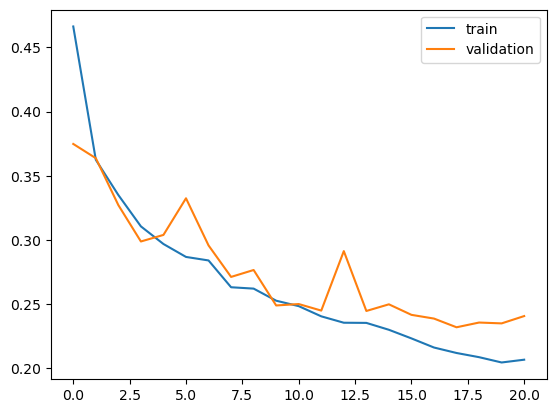

In [100]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()

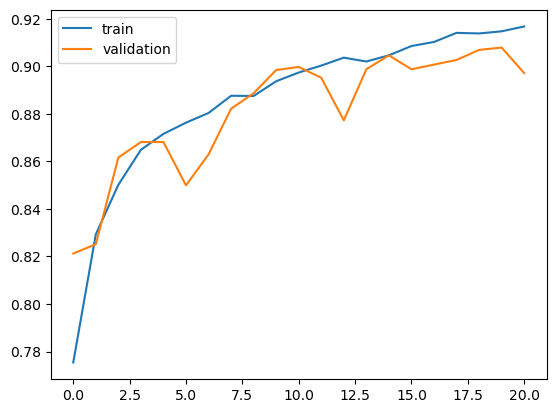

In [101]:
plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='validation')
plt.legend()

De plus, sur nos données test, on peut voir que la fonction de perte à également diminué. Pourtant, la précision n'a pas augmenté tant que ça. Nous avons donc une marge de progression.

In [96]:
evaluation = model.evaluate(test_generator, verbose=0)
print("Test loss:\t", evaluation[0])
print("Test accuracy:\t", evaluation[1])

Test loss:	 0.267894446849823
Test accuracy:	 0.8876991271972656



## 7. Amélioration des hyperparamètres

Maintenant que nous avons un modèle plus stable, nous pouvons essayer de le rendre encore plus stable et performant en optimisant ses hyperparamètres.

### a. hyperparamètres à optimiser

Les hyperparamètres sont des paramètres dont les valeurs contrôlent le processus d'apprentissage et déterminent les valeurs des paramètres du modèle qu'un algorithme d'apprentissage finit par apprendre. Le préfixe "hyper" suggère qu'il s'agit de paramètres de "niveau supérieur" qui contrôlent le processus d'apprentissage et les paramètres de modèle qui en découlent. [(source)](https://towardsdatascience.com/parameters-and-hyperparameters-aa609601a9ac)

C'est pour cela que l'optimisation des hyperparamètres est une notion clé pour l'entrainement d'un modèle. Dans notre cas, il y a trois hyperparamètres que nous souhaitons optimiser. 
1. le nombre de neurones dans la couche Fully connected
2. le dropour rate
3. le learning rate de l'algoritme d'optimisation

In [106]:
#CONFIG
AUTOTUNE = tf.data.experimental.AUTOTUNE

def create_model(hp):
      model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2,2)),

            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2,2)),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=hp.Int('units',
                                               min_value=128,
                                               max_value=192,
                                               step=64), 
                                  activation='relu'),
            tf.keras.layers.Dropout(rate=hp.Choice('dropout_1',
                                                   values=[0.1,0.2])),
            tf.keras.layers.Dense(1, activation='sigmoid')

      ])
      model.compile(optimizer=Adam(hp.Choice('learning_rate',
                                            values=[1e-3, 1e-4])),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5)])
      return model

### b. keras tuner

Afin d'optimiser ces hyper paramètres, nous utilisons keras-tuner, une librairie d'optimisation d'hyperparamètres. Etant donné que nous utilisons les librairies keras et Tensorflow pour la majorité de nos fonctions ici, il est plus judicieux d'utiliser une librairie compatible avec notre programme.

Ci dessous la commande requise pour installer keras-tuner :

In [107]:
#!pip install keras-tuner

Avec keras tuner, il existe 3 types d'approches pour optimiser les hyperparamètres [(source)](https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f):

- Random Search, similaire à Grid Search

Random Search est une manière de rechercher les paramètres les plus optimaux en essayant toutes les combinaisons possibles.

- Hyperband

Hyperband est une manière de rechercher les paramètres les plus optimaux qui remédie aux problèmes de Random Search : Random Search teste toutes les combinaisons possibles même si elles ne sont pas optimales, alors que Hyperband essaye au hasard toutes les combinaisons possibles mais, au lieu d'exécuter toutes les epochs, entraine les modèle sur quelques epochs (paramètre max_epochs) et sélectionne les meilleures combinaisons en fonction des résultats de ces quelques epochs. Cet approche est plutôt intéressante mais étant donné que nous n'avons pas beaucoup d'epochs à la base, et que nous avons un Early Stopping, cette approche n'est pas très utile dans notre cas.

- Bayesian Optimization

Bayezian Optimisation adresse les problèmes d'Hyperband et de Random Search : Au lieu que toutes les combinaisons d'hyperparamètres soient choisies aléatoirement, il choisit d'abord quelques-unes au hasard, puis en fonction des performances de ces hyperparamètres, il choisit les meilleurs hyperparamètres possibles suivants. Cette approche prend donc en compte l'historique des hyperparamètres qui ont été essayés. Les itérations consistant à choisir le prochain ensemble d'hyperparamètres en fonction de l'historique et à évaluer les performances se poursuivent jusqu'à ce que le tuner atteigne les hyperparamètres optimaux. Cette approche est également intéressante mais étant donné la faible diversité de nos hyperparamètres et leur faible nombre, cette approche n'est pas spécialement intéressante dans notre cas.

Nous allons donc implémenter le tuner avec RandomSearch.

In [111]:
import keras_tuner
from keras_tuner.tuners import RandomSearch

tuner = RandomSearch(
    create_model,
    objective='val_loss',
    max_trials=12,
    executions_per_trial=1,
    directory=log_dir,
    project_name=project_name,
)

tuner.search(
    train_generator,
    epochs=20, 
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)],
    validation_data=valid_generator,
)

tuner.results_summary()

Trial 7 Complete [00h 58m 19s]
val_loss: 0.24799291789531708

Best val_loss So Far: 0.21263743937015533
Total elapsed time: 07h 13m 19s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in /Users/soja/Downloads/LIVRABLE1G2/L1G2
Showing 10 best trials
Trial summary
Hyperparameters:
units: 192
dropout_1: 0.1
learning_rate: 0.0001
Score: 0.21263743937015533
Trial summary
Hyperparameters:
units: 192
dropout_1: 0.2
learning_rate: 0.0001
Score: 0.22791191935539246
Trial summary
Hyperparameters:
units: 192
dropout_1: 0.1
learning_rate: 0.001
Score: 0.23766010999679565
Trial summary
Hyperparameters:
units: 128
dropout_1: 0.1
learning_rate: 0.0001
Score: 0.23858261108398438
Trial summary
Hyperparameters:
units: 192
dropout_1: 0.2
learning_rate: 0.001
Score: 0.24799291789531708
Trial summary
Hyperparameters:
units: 128
dropout_1: 0.2
learning_rate: 0.0001
Score: 0.25475749373435974
Trial summary
Hyperparameters:
units: 128
dropout_1: 0.2
learning_rate: 0.001
Score: 0.2759752273559570

### c. meilleur hypermodel

- ###### meilleurs hyperparamètres

In [112]:
best_hps=tuner.get_best_hyperparameters()[0]

print("Les meilleurs hyperparamètres sont", best_hps.get('units'),
      "neurones dans la couche Dense fully connected, un dropout rate de"
      , best_hps.get('dropout_1'), "après les couches convolutives et un learning rate de "
      , best_hps.get('learning_rate'), "pour l'algorithme d'optimisation Adam.")

Les meilleurs hyperparamètres sont 192 neurones dans la couche Dense fully connected, un dropout rate de 0.1 après les couches convolutives et un learning rate de  0.0001 pour l'algorithme d'optimisation Adam.


- ###### entrainement avec la meilleure combinaison d'hyperparamètres

Nous allons maintenant entrainer notre modèle avec les meilleurs hyperparamètres trouvés par notre tuner.On ajoute toujours le Early Stopping.

In [117]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(train_generator, epochs=25, validation_data=valid_generator, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/25


2022-10-17 10:34:17.298847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


384/384 [==============================] - ETA: 0s - loss: 0.4670 - binary_accuracy: 0.7833

2022-10-17 10:36:40.066099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


384/384 [==============================] - 177s 460ms/step - loss: 0.4670 - binary_accuracy: 0.7833 - val_loss: 0.3812 - val_binary_accuracy: 0.8203
Epoch 2/25
384/384 [==============================] - 175s 456ms/step - loss: 0.3480 - binary_accuracy: 0.8370 - val_loss: 0.3298 - val_binary_accuracy: 0.8404
Epoch 3/25
384/384 [==============================] - 178s 462ms/step - loss: 0.3193 - binary_accuracy: 0.8550 - val_loss: 0.3607 - val_binary_accuracy: 0.8339
Epoch 4/25
384/384 [==============================] - 177s 461ms/step - loss: 0.3024 - binary_accuracy: 0.8676 - val_loss: 0.2880 - val_binary_accuracy: 0.8759
Epoch 5/25
384/384 [==============================] - 174s 454ms/step - loss: 0.2806 - binary_accuracy: 0.8768 - val_loss: 0.2765 - val_binary_accuracy: 0.8808
Epoch 6/25
384/384 [==============================] - 174s 452ms/step - loss: 0.2751 - binary_accuracy: 0.8833 - val_loss: 0.2837 - val_binary_accuracy: 0.8717
Epoch 7/25
384/384 [==============================]

### c. évaluation et prédicitons

- ###### évaluations

Selon les tracés ci dessous sur la fonction de perte et la précision sur les dataset train et validation, on remarque que les variances sont moins elevées entre les deux courbes par rapport au modèle précédent. Cependant, il y a quand même des pics, un peu plus que sur les courbes du modèle précédent.

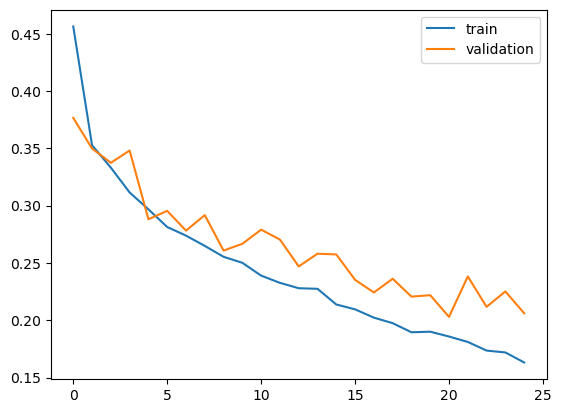

In [146]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()

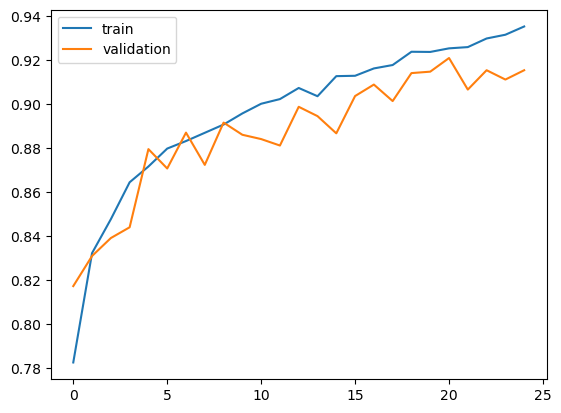

In [147]:
plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='validation')
plt.legend()

Selon l'évaluation du modèle sur le dataset test, on voit qu'on améliore la précision du modèle et on minimise la fonction de perte. C'est une petite amélioration par rapport au modèle précédent.

In [148]:
evaluation = model.evaluate(test_generator, verbose=0)
print("Test loss:\t", evaluation[0])
print("Test accuracy:\t", evaluation[1])

Test loss:	 0.21331924200057983
Test accuracy:	 0.9112039804458618


- ###### prédicitons

1/1 [==============================] - 0s 10ms/step


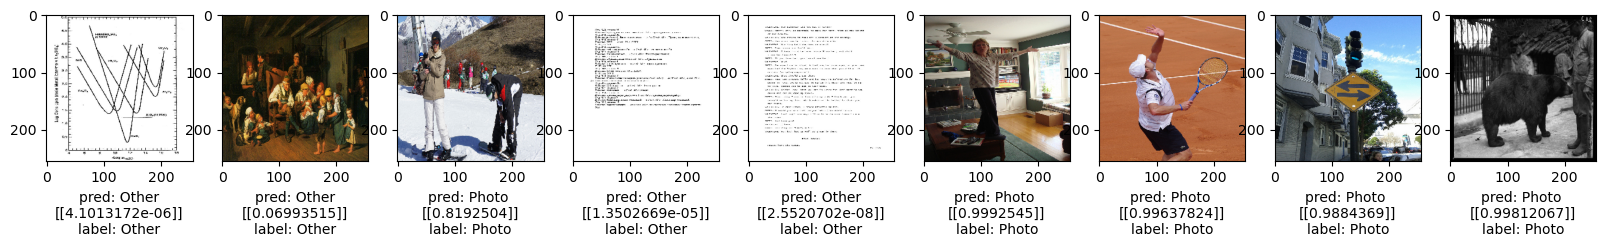

In [154]:
plt.figure(figsize=(20,20 ))

for image, label in test_generator:
    for i in range(9):
        ax =  plt.subplot(1, 9, i + 1)
        plt.imshow(image[i])
        X = np.expand_dims(image[i],axis=0)
        val = model.predict(X)
        l = "Other"
        if label[i] == 1:
            l = "Photo"
        if val > 0.5:
            plt.xlabel("pred: Photo " + "\n" + str(val)+ "\n" + "label: " + l,fontsize=10)
        else:
            plt.xlabel("pred: Other" + "\n" + str(val)+ "\n"+ "label: " + l,fontsize=10)
    break

Nous pouvons observer que, sur cet échantillon de 9 images, le modèle final ne se trompe sur aucune image. C'est aussi une petite amélioration par rapport aux modèles précédents. 

## 8. Conclusion

Nous avons choisi l'architecture des réseaux de neurones convolutifs pour notre classification binaire. Afin de mener à bien les prédictions, nous avons effectué un prétraitement sur nos données, comme par exemple supprimer les données mal encodées ou importer les données de manière équilibrée et stratifiée.

Ensuite, nous avons implémenté notre modèle en utilisant des paramètres plutôt standard. De là, en intéreprétant les résultats, nous avons mis en place plusieurs améliorations pour avoir des résultats plus stables :
- ajouter une couche de dropout pour forcer le modèle à créer d'autre connexion moins directes
- modifier nos données en les tournant, redimensionnant ect... pour avoir des données plus variées (data augmentation)
- optimiser les hyperparamètres du modèle à l'aide de keras tuner en utilisant l'approche random search

A la suite de toutes ces étapes, nous avons donc obtenu des résultats plus satisfaisants que ceux que nous avions eu au départ. Cependant, il y a toujours un petit manque de stabilité au niveau de nos courbes de précision et de la fonction de perte sur de dataset validation.

On peut donc imaginer qu'on aurait pu implémenter un réseau de neurones plus complexe, avec beaucoup plus d'hyperparamètres à optimiser. Nous aurions peut être tendu vers une courbe de précision et de fonction de perte plus stable. De plus, si nous avions eu de meilleures performances matérielles, nous aurions pu générer plus de données et mieux entrainer notre modèle, et donc peut être mieux prédire.

Nous pouvons maintenant sauvegarder notre modèle.

In [145]:
model.save('./classification_binaire.h5')